## Importation des librairies et des données

In [184]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import DBSCAN
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import boxcox
from scipy.stats import yeojohnson
from sklearn.preprocessing import StandardScaler

In [185]:
data = pd.read_csv('rfm_scaled.csv')
rfm = pd.read_csv('rfm.csv')
#df_full = pd.read_csv('data.csv')
df_full_no_scaled = pd.read_csv('data_no_scaled.csv')

In [186]:
data.head()

,last_purchase,number_orders,payment_total
0,-0.828911,-0.164234,-0.102934
1,-0.809254,-0.164234,-0.609793
2,1.962393,-0.164234,-0.348962
3,0.547084,-0.164234,-0.537195
4,0.330856,-0.164234,0.140045


## Pre-Processing

In [187]:
df_full_no_scaled.columns

Index(['review_score', 'days_of_waiting', 'days_of_waiting_2',
       'geolocation_lat', 'geolocation_lng', 'freight_by_price',
       'mean_item_per_order', 'boleto', 'credit_card', 'debit_card', 'voucher',
       'distance_bet_cust_n_sell', 'last_purchase', 'number_orders',
       'payment_total'],
      dtype='object')

In [188]:
df_full_no_scaled['freight_by_price'].describe()

count    91420.000000
mean         0.308850
std          0.312682
min          0.000000
25%          0.132842
50%          0.225316
75%          0.381892
max         21.447059
Name: freight_by_price, dtype: float64

In [189]:
identite = lambda x : x
sqrt = lambda x : x**(1/2)
resiprocal = lambda x : (1/x)

In [190]:
liste_func = [identite, np.log10, sqrt, resiprocal, boxcox, yeojohnson]
liste_name = ['identité', 'logarithmique', 'sqrt', 'réciproque', 'boxcox', 'yeojohnson']
liste_var = ['days_of_waiting', 'days_of_waiting_2', 'review_score', 'freight_by_price', 'distance_bet_cust_n_sell', 'last_purchase',
            'number_orders', 'payment_total']
df = df_full_no_scaled
def transformation(df, liste_var, liste_func):
    for var in liste_var:
        for func in liste_func:
            if (func == boxcox) or (func == yeojohnson):
                try:
                    print('skewness de', var, 'après transformation', liste_name[liste_func.index(func)], pd.Series(func(df[var])[0]).skew())
                    print('kurtosis de', var, 'après transformation', liste_name[liste_func.index(func)], pd.Series(func(df[var])[0]).kurt())
                except ValueError:
                    print('Transformation impossible')
            else:                
                print('skewness de', var, 'après transformation', liste_name[liste_func.index(func)], pd.Series(func(df[var])).skew())
                print('kurtosis de', var, 'après transformation', liste_name[liste_func.index(func)], pd.Series(func(df[var])).kurt())
        print('---------------------------')

transformation(df, liste_var, liste_func)


skewness de days_of_waiting après transformation identité 3.8406345610174095
kurtosis de days_of_waiting après transformation identité 39.7324710226943
skewness de days_of_waiting après transformation logarithmique -0.012158694859112128
kurtosis de days_of_waiting après transformation logarithmique 0.23075470278708332
skewness de days_of_waiting après transformation sqrt 1.1929773003592106
kurtosis de days_of_waiting après transformation sqrt 3.9406213065972655
skewness de days_of_waiting après transformation réciproque 2.0918141011497857
kurtosis de days_of_waiting après transformation réciproque 6.321478571643425
skewness de days_of_waiting après transformation boxcox 0.00029040862232525093
kurtosis de days_of_waiting après transformation boxcox 0.23575940125166284
skewness de days_of_waiting après transformation yeojohnson -0.001893394321948473
kurtosis de days_of_waiting après transformation yeojohnson 0.09614784218717709
---------------------------
skewness de days_of_waiting_2 ap

A l'aide des résultats précédents on sélectionne les meilleurs transformations pour chacune des variables :
- days_of_waiting : yeojohnson
- days_of_waiting_2 : sqrt 
- review_score : boxcox
- freight_by_price : yeojohnson
- distance_bet_cust_n_sell : yeojohnson
- last_purchase : boxcox 
- number_orders : yeojohnson
- payment_total : boxcox 

In [191]:
transformation_dic = {
    'days_of_waiting' : yeojohnson,
    'review_score' : boxcox,
    'freight_by_price' : yeojohnson,
    'distance_bet_cust_n_sell' : yeojohnson,
    'last_purchase' : boxcox,
    'number_orders' : yeojohnson,
    'payment_total' : boxcox
}

In [192]:
df = df_full_no_scaled.copy()
for clef, func in transformation_dic.items():
    if (func == boxcox) or (func == yeojohnson):
        df[clef] = pd.Series(func(df[clef])[0])
    else:
        df[clef] = func(df[clef])

In [193]:
# Création de l'objet scaler
scaler = StandardScaler()

# Normalisation des données numériques
df_full = scaler.fit_transform(df)

In [194]:
df_full = pd.DataFrame(df_full, columns=df.columns).set_index(df.index, df.index.name)

In [195]:
df

,review_score,days_of_waiting,days_of_waiting_2,geolocation_lat,geolocation_lng,freight_by_price,mean_item_per_order,boleto,credit_card,debit_card,voucher,distance_bet_cust_n_sell,last_purchase,number_orders,payment_total
0,30.512257,1.891068,-5.0,-23.369587,-46.842322,0.077132,1.0,0.0,1.0,0.0,0.0,0.732292,21.937984,0.021729,3.123778
1,16.306010,1.494989,-5.0,-23.536561,-46.788284,0.216547,1.0,0.0,1.0,0.0,0.0,0.148405,22.280987,0.021729,2.406167
2,7.167083,2.866137,-2.0,-27.580259,-48.631961,0.160123,1.0,0.0,1.0,0.0,0.0,1.900801,53.805884,0.021729,2.932142
3,16.306010,2.687139,-12.0,-1.452536,-48.391746,0.255402,1.0,0.0,1.0,0.0,0.0,3.658809,40.296798,0.021729,2.636587
4,30.512257,2.394504,-8.0,-23.485346,-47.464450,0.078137,1.0,0.0,1.0,0.0,0.0,0.962454,37.899390,0.021729,3.239594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91415,30.512257,2.916613,-27.0,-8.362623,-36.562478,0.185392,2.0,0.0,1.0,0.0,0.0,3.410033,48.552010,0.021729,3.878946
91416,16.306010,2.963539,-3.0,-12.250013,-38.956962,0.179721,1.0,0.0,1.0,0.0,0.0,3.083359,35.920690,0.021729,2.924360
91417,30.512257,2.491285,-30.0,-11.858332,-55.508463,0.160669,1.0,0.0,1.0,0.0,0.0,3.091736,55.520602,0.021729,3.036750
91418,30.512257,2.340674,-14.0,-21.126568,-41.672806,0.119923,1.0,0.0,1.0,0.0,0.0,2.158137,22.843673,0.021729,3.101862


## K-Means

In [196]:
X_norm = data.values

In [197]:
#Find the best number of cluster
#intertia_list = []

#for i in range(2,6):
 #   KM = KMeans(n_clusters = i)
  #  KM.fit(X_norm)
   # clus = KM.labels_
    #print(silhouette_score(X_norm,clus))
    #intertia_list.append(KM.inertia_)

0.7351445008727123
\
0.4566758116357803
\
0.4886662125569798
\
0.41850411642625107

In [198]:
#Affichage de la courbe du nombre de cluster en fonction de l'inertie
#fig, ax = plt.subplots(1,1,figsize=(12,6))

#ax.set_ylabel("intertia")
#ax.set_xlabel("n_cluster")

#ax = plt.plot(range(2, 6), intertia_list)

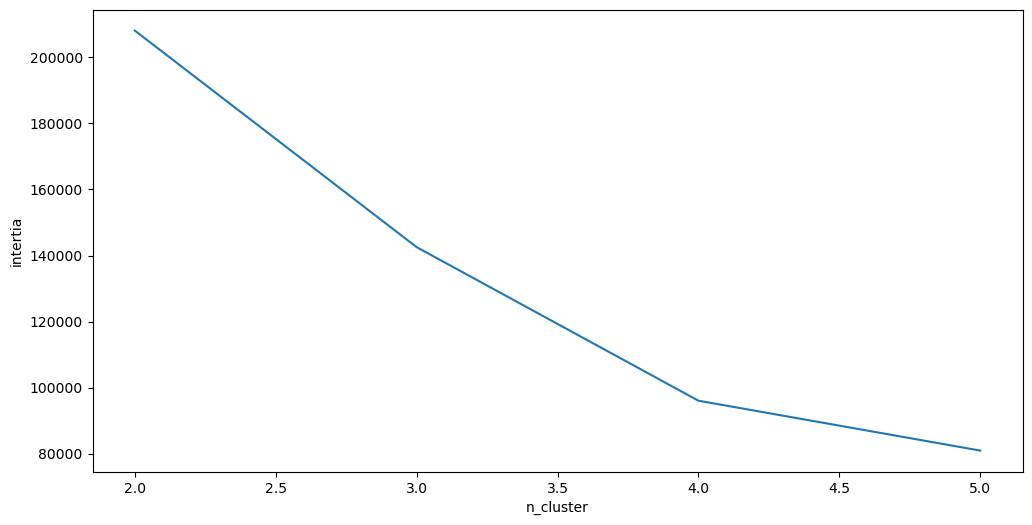

Dans un premier temps l'étude du score de silhouette nous apprends que 2 clusters seraient l'idéal. Cependant, on veut une partition plus complexe. On décide donc de regarder les autres valeurs. On observe que 4 clusters obtient un très bon score de silhouette. De plus, en observant le graphique du degré d'inertie en fonction du nombre de cluster on remarque qu'il y a un coude à 4 clusters. Ces deux méthodes nous confortent dans l'idée de faire un partitionnement à 4 clusters pour RFM.

In [199]:
#Partitionnement à 4 clusters par K-Means
KM = KMeans(n_clusters = 4,random_state=0)
KM.fit(X_norm)
clus = KM.labels_

In [200]:
#ACP à 3 composantes
pca = PCA(n_components = 3)
X_pca = pca.fit_transform(X_norm)

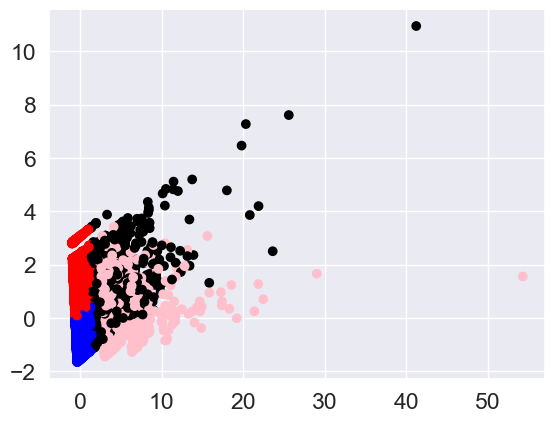

In [201]:
#Observation des 4 clusters sur le premier plan factoriel
colors = ['red','blue','pink', 'black']
plt.scatter(X_pca[:, 0], X_pca[:, 1], c= clus, cmap=ListedColormap(colors))
plt.show()

Afin d'utiliser la CAH et DBScan, on a besoin de sélectionner un échantillon de notre dataframe (car sinon trop volumineux et incapacité pour ces modèles de fonctionner).

### Echantillonnage

In [202]:
#On sélectionne 10% du dataframe original
data_sample = data[['last_purchase', 'number_orders', 'payment_total']].sample(frac=0.1, replace=True, random_state=1).values

In [203]:
data_sample.shape

(9336, 3)

## CAH

In [204]:
#linked = linkage(data_sample, 'ward', metric='euclidean')

#labelList = range(1, data_sample.shape[0]+1)

#plt.figure(figsize=(10, 7))
#dendrogram(linked,
#            orientation='top',
#            labels=labelList,
#            distance_sort='descending',
#            show_leaf_counts=True, truncate_mode='level', p=4)
#plt.axhline(y=80, c='r', linewidth=1)

#plt.xlabel("Clusters")
#plt.ylabel("Distance")
#plt.title("Dendrogramme du CAH",
#          fontsize=18,
#          color="b")
#plt.show()

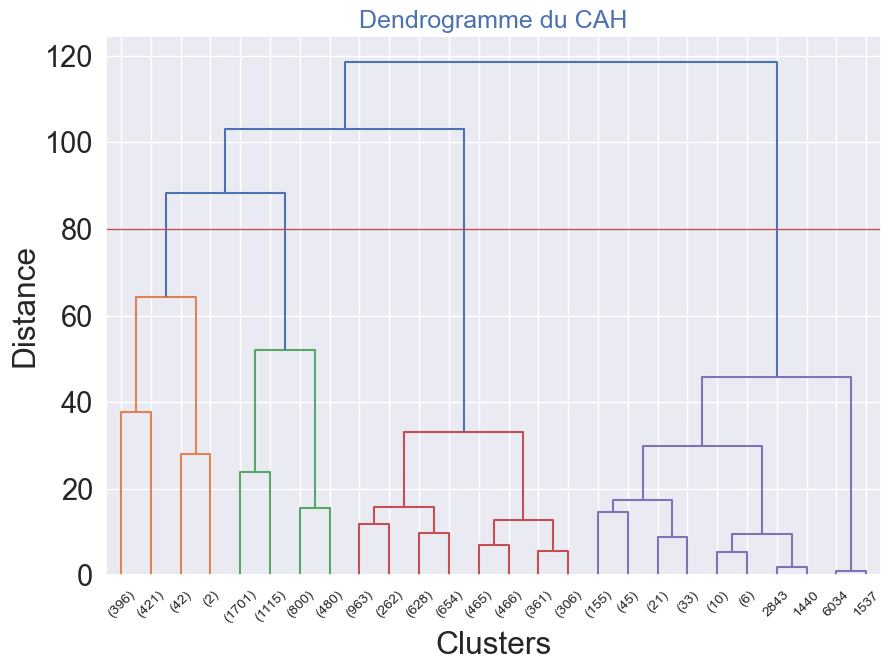

## DBScan

In [205]:
#ACP à 3 composantes sur l'échantillon 
pca = PCA(n_components = 3)
data_pca = pca.fit_transform(data_sample)

In [206]:
#DBScan
DB = DBSCAN(min_samples=4,eps=2.3)
DB.fit(data_sample)
clus = DB.labels_

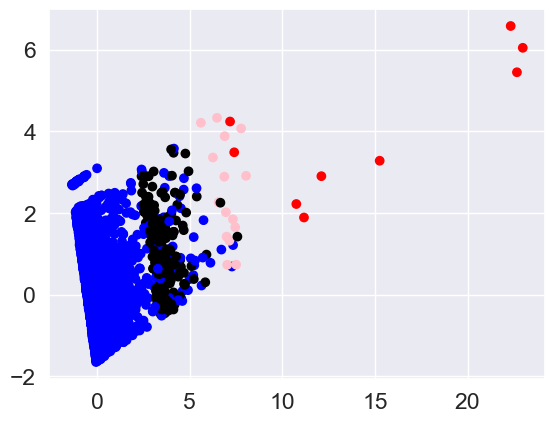

In [207]:
#Affichage des 4 clusters du DBScan sur le premier plan factoriel
plt.scatter(data_pca[:, 0], data_pca[:, 1], c= clus, cmap=ListedColormap(colors))
plt.show()

## Etude des clusters à l'aide de la régression logistique

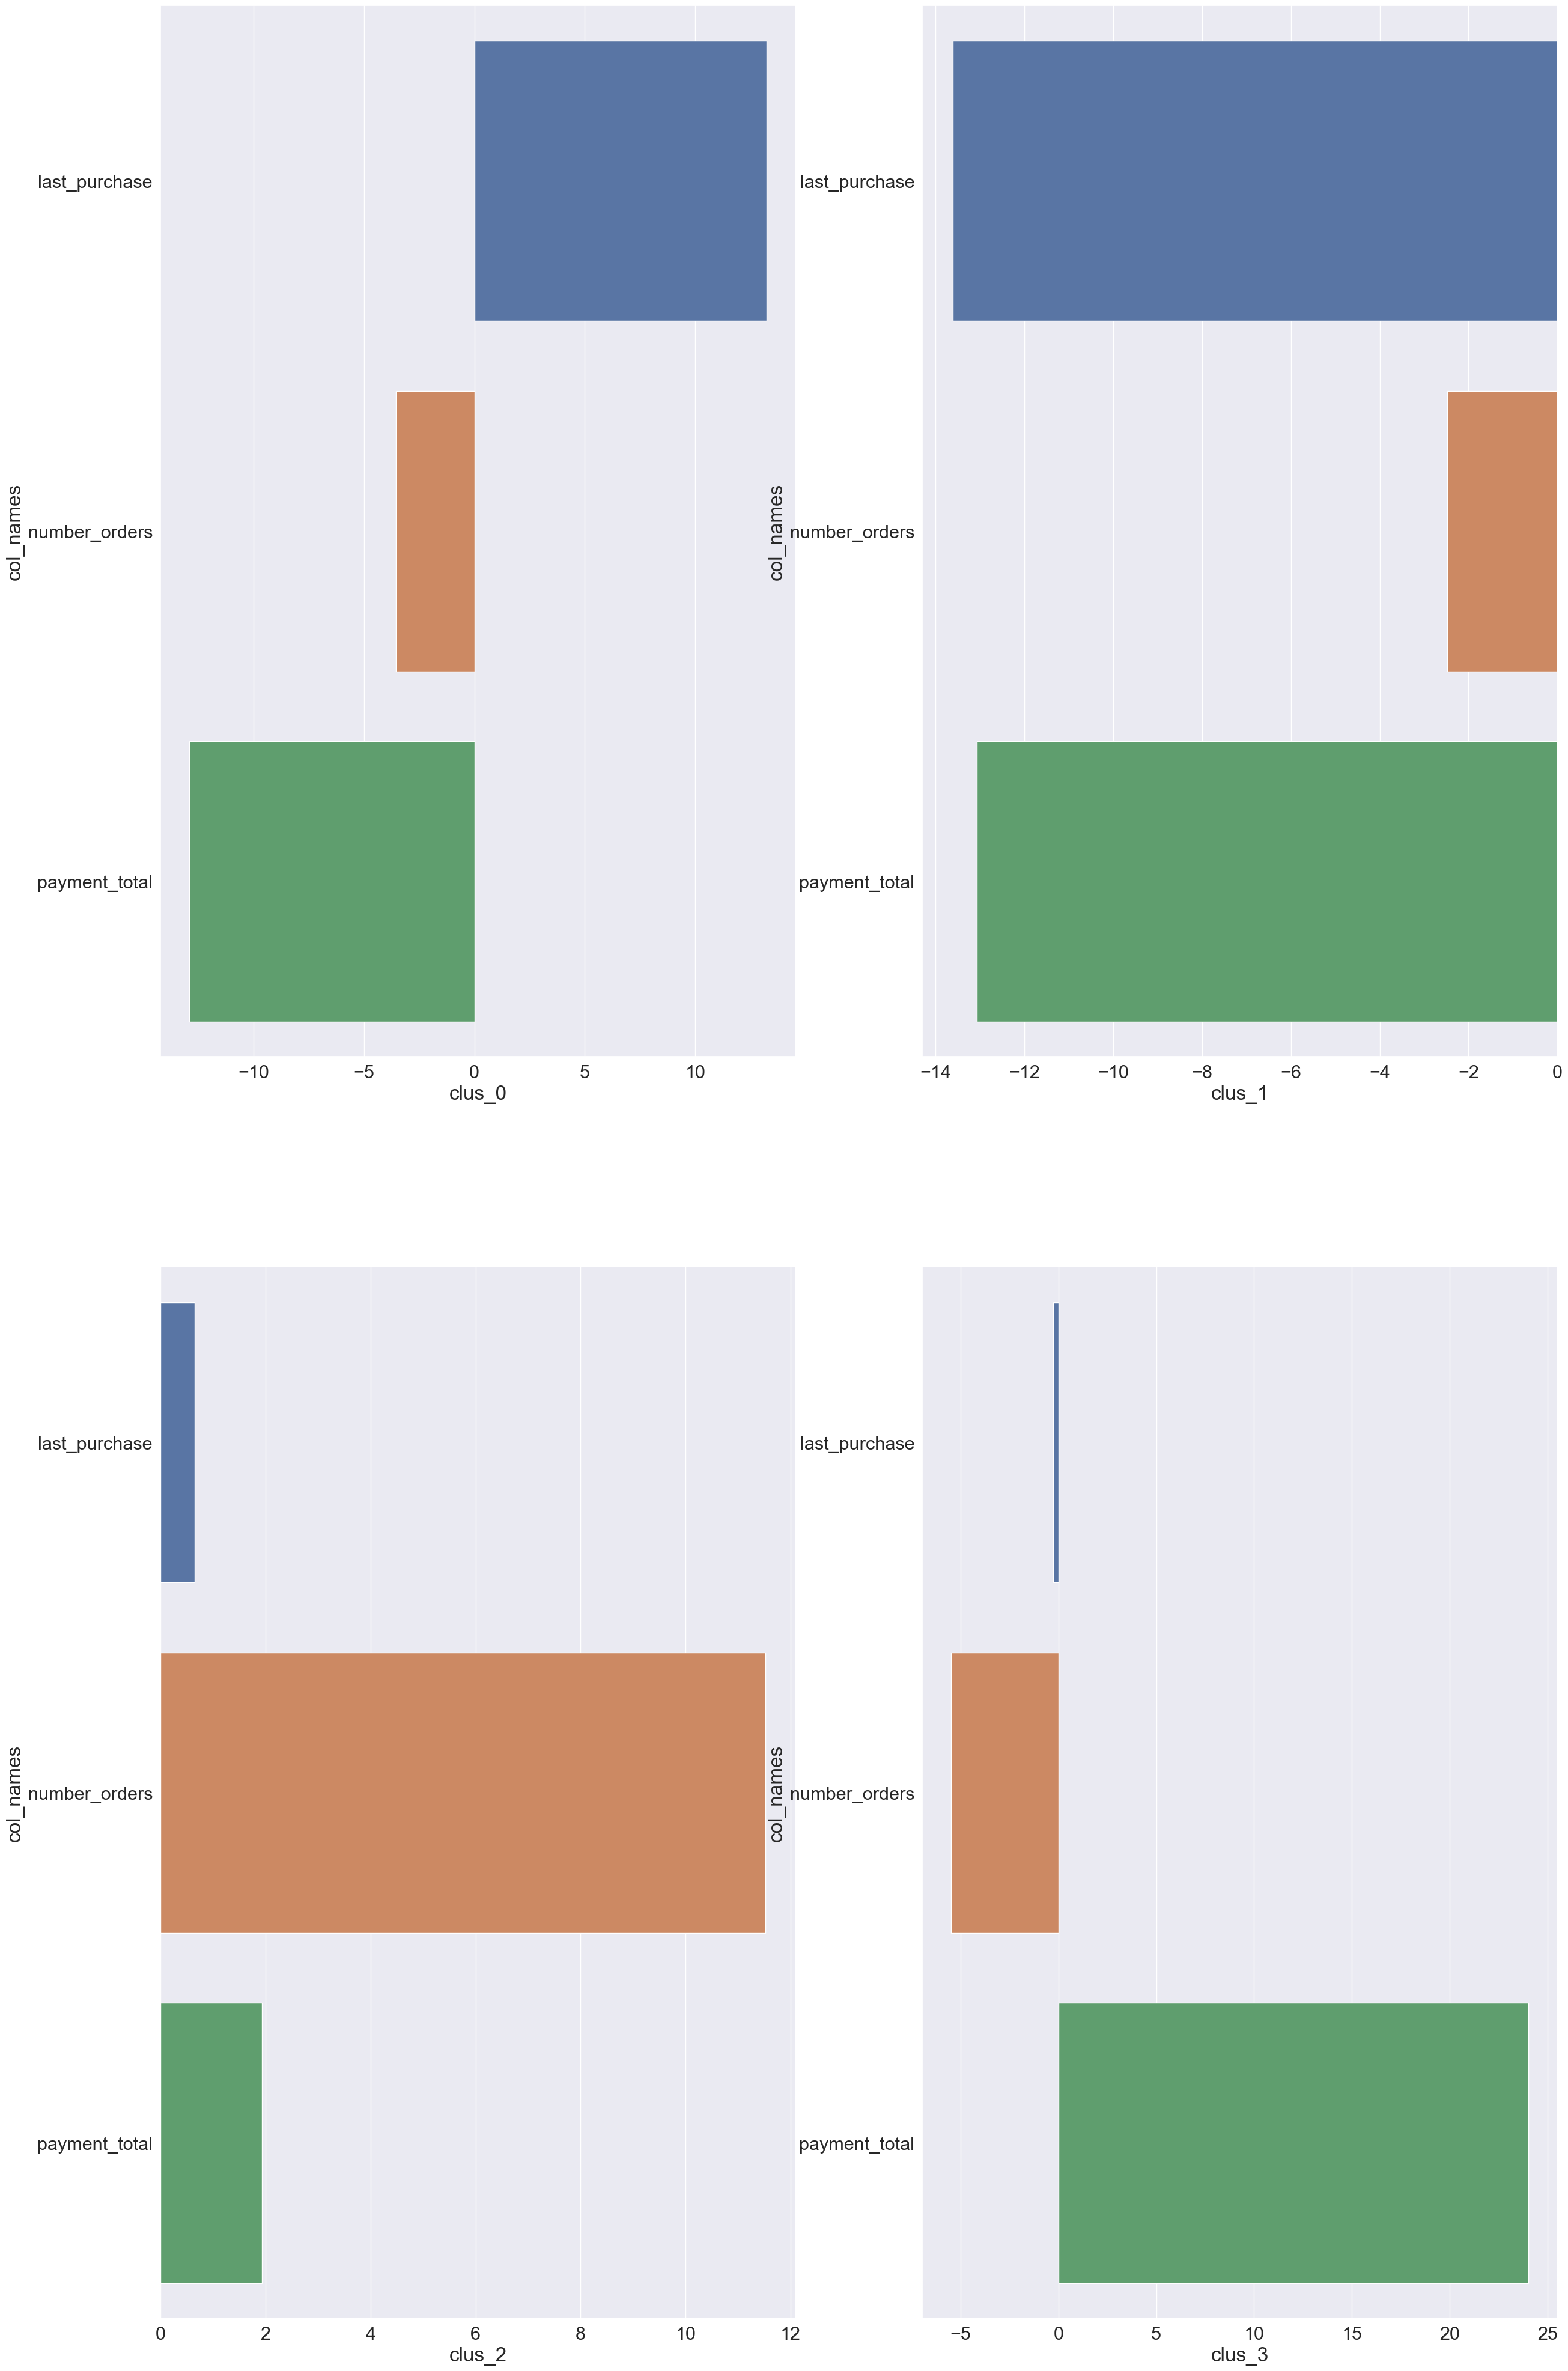

In [208]:
#We apply Kmeans
KM = KMeans(n_clusters = 4, random_state=0)
KM.fit(X_norm)
y = KM.labels_

#We apply the logistic regression
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(penalty='l2')
LR.fit(X_norm,y)

#We vizualize our coefficients
import numpy as np
df_clusInter = pd.DataFrame(np.concatenate((data.columns.values.reshape(-1,1), LR.coef_.T),axis=1), 
                            columns=['col_names', 'clus_0', 'clus_1', 'clus_2', 'clus_3'])

import seaborn as sb
sb.set(font_scale=2)
x_ax = 'col_names'
f, axes = plt.subplots(2,2,figsize=(30,50))
for i, ax in zip(range(0,4), axes.flat):
    sb.barplot(y=x_ax, x=df_clusInter.columns[1:].tolist()[i], data=df_clusInter,ax=ax)

Les facteurs de la régression logistique nous indique les caractéristiques principales définissant nos clusters :
- Cluster 0 : Clients ayant effectué leurs derniers achats il y a longtemps (relativement aux autres).
- Cluster 1 : Clients ayant leurs derniers achats il n'y a pas longtemps (relativement aux autres).
- Cluster 2 : Clients ayant effectué le plus de commandes.
- Cluster 3 : Clients ayant effectué des commande onéreuses.

## Cardinalité

<AxesSubplot:xlabel='0', ylabel='count'>

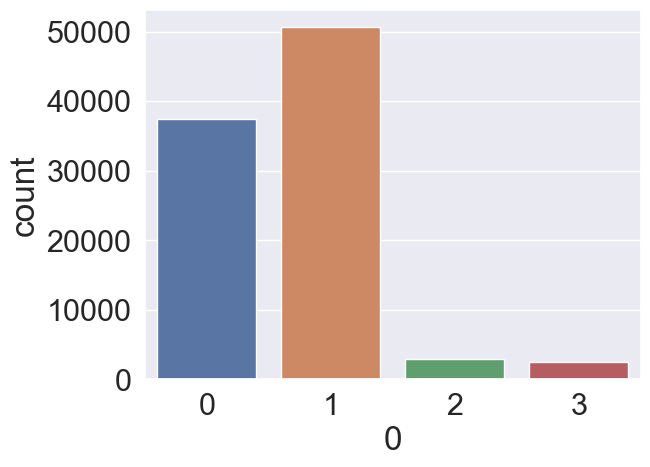

In [209]:
sns.countplot(data=pd.DataFrame(y), x=0)

Les clusters sont peu équilibrés en proportion d'individu.

## Magnitude

<AxesSubplot:xlabel='label'>

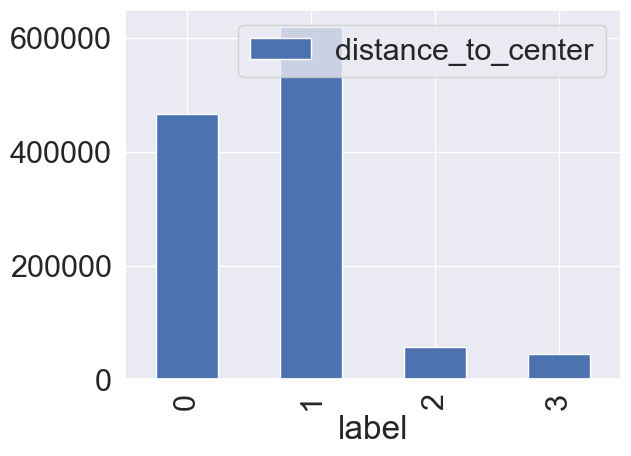

In [210]:
dist = KM.transform(X_norm).sum(axis=1)
df = pd.DataFrame(dist.round(2), columns=['distance_to_center'])
df['label'] = KM.labels_
df.groupby('label').sum().plot(kind='bar')

La magnitude, c'est à dire la somme des distances entre les observations et le centre de leurs clusters respectifs est très peu équilibré.

In [211]:
rfm['cluster_rfm'] = y
rfm.groupby('cluster_rfm').mean()

,last_purchase,number_orders,payment_total
cluster_rfm,,,
0,388.224583,1.000000,133.474883
1,128.854174,1.000000,134.234268
2,222.569586,2.116429,282.204973
3,239.826033,1.014876,1160.203525


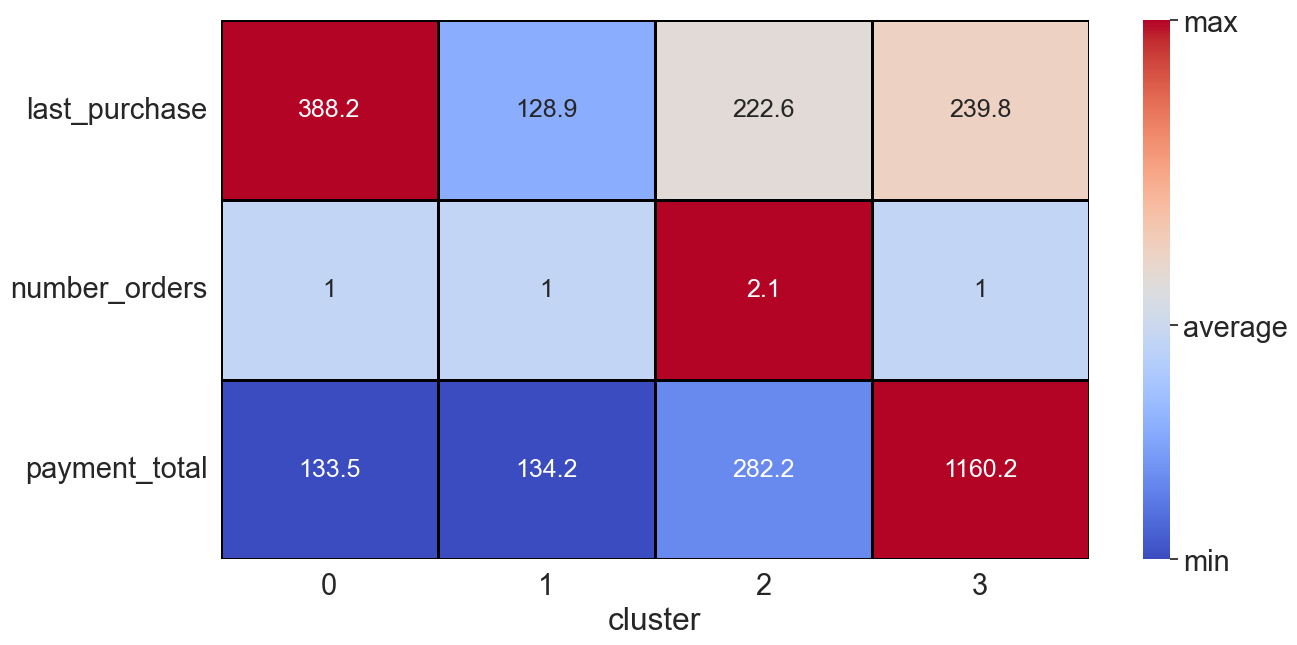

In [212]:
rfm['cluster'] = y
sales = per_source_cat = np.round(rfm[['last_purchase', 'number_orders', 'payment_total', 'cluster']].groupby('cluster').mean(),1).T
# create a dataframe grouped by Sources and Category
per_source_cat = np.round(rfm[['last_purchase', 'number_orders', 'payment_total', 'cluster']].groupby('cluster').mean(),1).T
# calculate the maximum for each source
max_per_source = per_source_cat.max(axis=1)
# divide the sales of each source by the maximum for that source
per_source_cat = per_source_cat.div(max_per_source, axis=0) * 100

sns.set(font_scale=1.9)
plt.figure(figsize=(14,7))
ax = sns.heatmap(per_source_cat, cmap='coolwarm', annot=sales, fmt='g', linewidths=1, linecolor='black', 
                 annot_kws={"fontsize":18}, xticklabels=True)
cbar = ax.collections[0].colorbar
cbar.set_ticks([11.5, 50, 100])
cbar.set_ticklabels(['min', 'average', 'max'])
plt.show()

On peut à l'aide du tableau ci-dessus nommer les différents clusters que l'on vient de trouver : 
- Cluster 0 : least_recent car a une moyenne de jour passé depuis la dernière commande significativement supérieur à la moyenne des autres clusters
- Cluster 1 : most_recent car a une moyenne de jour passé depuis la dernière commande significativement inférieur à la moyenne des autres clusters
- Cluster 2 : most_orders car a une moyenne de commande significativement supérieur à la moyenne des autres clusters
- Cluster 3 : biggest_spenders car a une moyenne des dépenses totales significativement supérieur à la moyenne des autres clusters


In [213]:
rfm.loc[rfm['cluster_rfm']==0,'cluster_rfm'] = 'least_recent'
rfm.loc[rfm['cluster_rfm']==1,'cluster_rfm'] = 'most_recent'
rfm.loc[rfm['cluster_rfm']==2,'cluster_rfm'] = 'most_orders'
rfm.loc[rfm['cluster_rfm']==3,'cluster_rfm'] = 'biggest_spenders'

<AxesSubplot:xlabel='last_purchase', ylabel='cluster_rfm'>

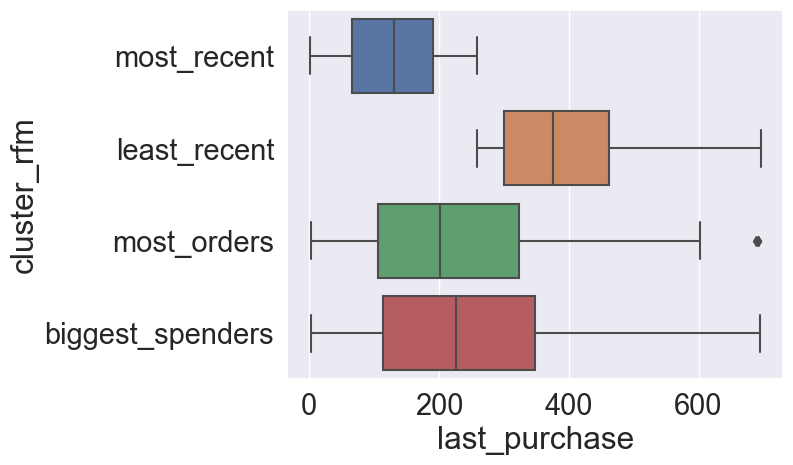

In [214]:
sb.boxplot(y='cluster_rfm', x='last_purchase', data=rfm)

In [215]:
rfm[['number_orders', 'cluster_rfm']].groupby('cluster_rfm').value_counts()

cluster_rfm       number_orders
biggest_spenders  1                 2387
                  2                   31
                  3                    1
                  4                    1
least_recent      1                37367
most_orders       2                 2698
                  3                  200
                  4                   29
                  5                    8
                  6                    6
                  7                    3
                  9                    1
                  17                   1
most_recent       1                50622
dtype: int64

<AxesSubplot:xlabel='payment_total', ylabel='cluster_rfm'>

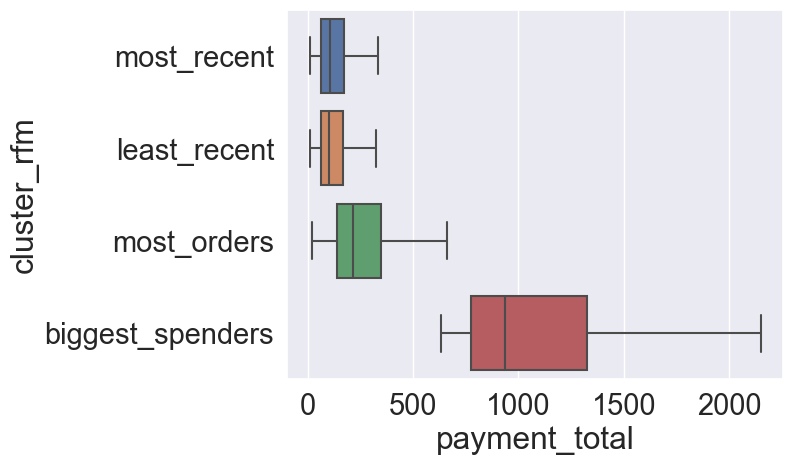

In [216]:
sb.boxplot(y='cluster_rfm',x='payment_total',data=rfm, showfliers = False)

# Segmentation a plusieurs variables

In [280]:
df_full.head()

,review_score,days_of_waiting,days_of_waiting_2,geolocation_lat,geolocation_lng,freight_by_price,mean_item_per_order,boleto,credit_card,debit_card,voucher,distance_bet_cust_n_sell,last_purchase,number_orders,payment_total
0,0.767872,-0.783124,0.685482,-0.392908,-0.161428,-1.144965,-0.265622,-0.501145,0.544399,-0.126371,-0.199907,-1.040851,-0.737412,-1.387779e-17,0.379147
1,-0.495717,-1.693685,0.685482,-0.422834,-0.148025,0.932013,-0.265622,-0.501145,0.544399,-0.126371,-0.199907,-1.653145,-0.711635,-1.387779e-17,-1.966373
2,-1.308588,1.458498,0.983339,-1.147564,-0.605324,0.091408,-0.265622,-0.501145,0.544399,-0.126371,-0.199907,0.184506,1.657474,-1.387779e-17,-0.247217
3,-0.495717,1.046991,-0.009519,3.535170,-0.545741,1.510855,-0.265622,-0.501145,0.544399,-0.126371,-0.199907,2.028044,0.642261,-1.387779e-17,-1.213242
4,0.767872,0.374243,0.387624,-0.413655,-0.315738,-1.129986,-0.265622,-0.501145,0.544399,-0.126371,-0.199907,-0.799491,0.462094,-1.387779e-17,0.757694


In [281]:
X_norm = df_full.values

In [282]:
#Find the best number of cluster
intertia_list = []

for i in range(2,14):
    KM = KMeans(n_clusters = i)
    KM.fit(X_norm)
    clus = KM.labels_
    print(silhouette_score(X_norm,clus))
    intertia_list.append(KM.inertia_)

0.24363956785326973
0.22569145256828746
0.22919563999174333
0.15590386659977803
0.1656623658414058
0.1644654676112482
0.17277554932040537
0.1673448212960709
0.16167350640422495
0.14978546950645122
0.14456840464095416
0.14706785067211126


2 clusters : 0.2564215455934126
\
3 clusters : 0.2687732506364924
\
4 clusters : 0.2675720929037031
\
5 clusters : 0.2933043173832452
\
6 clusters : 0.3041078532093928
\
7 clusters : 0.31077790055540466
\
8 clusters : 0.31480013479351515
\
9 clusters : 0.18687866286700125
\
10 clusters : 0.18949804885039423
\
11 clusters : 0.19261449240089062
\
12 clusters : 0.1681784208171977
\
13 clusters : 0.1982524657193588

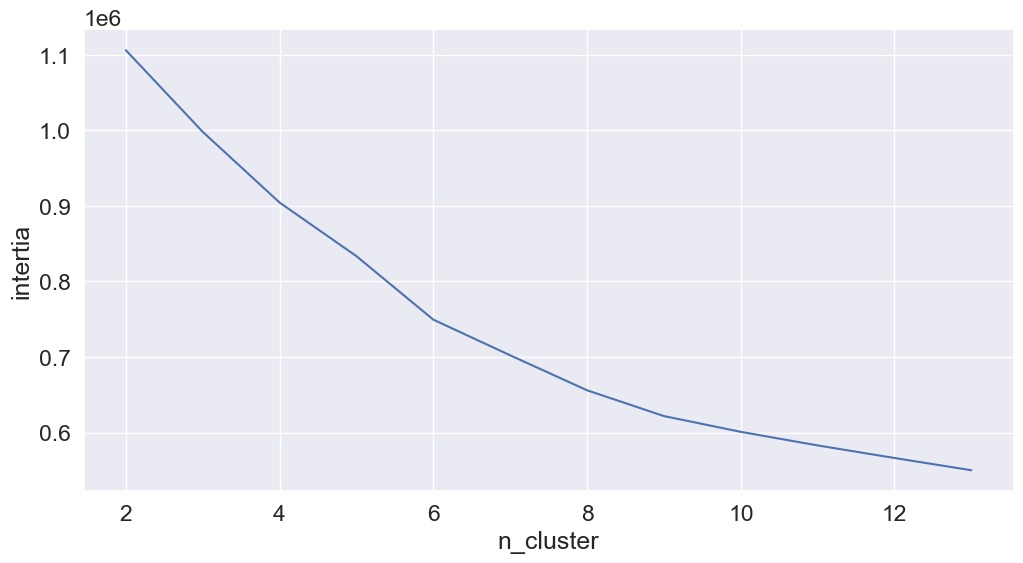

In [283]:
#Affichage de la courbe du nombre de cluster en fonction de l'inertie
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")

ax = plt.plot(range(2, 14), intertia_list)

Le score de silhouette montre que 8 clusters serait le plus pertinent. Le graphe du degré d'inertie en fonction du nombre de cluster n'est pas pertinent pour ce choix car on ne remarque pas de réel coude.

## K-Means

In [284]:
#Production d'un K-Means à 8 clusters
KM = KMeans(n_clusters = 8, random_state=1)
KM.fit(X_norm)
clus = KM.labels_

In [285]:
#ACP à 3 composantes
pca = PCA(n_components = 3)
X_pca = pca.fit_transform(X_norm)

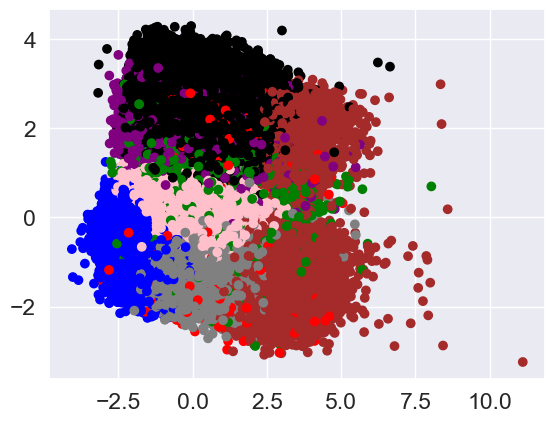

In [286]:
#Projection des clusters sur le premier plan factoriel
colors = ['red','blue','pink', 'black', 'green', 'grey', 'brown', 'purple']
plt.scatter(X_pca[:, 0], X_pca[:, 1], c= clus, cmap=ListedColormap(colors))
plt.show()

Afin de préparer au mieux la CAH et le DBScan, on décide de sélectionner un échantillon de notre dataframe d'origine (car le dataframe d'origine est beaucoup trop lourd pour ces méthodes de clustering).

## Echantillonnage

In [287]:
#Sélection de 20% du dataframe d'origine
data_sample = df_full.sample(frac=0.2, replace=False, random_state=1).values

## CAH

In [288]:
#Production d'une CAH/d'un dendrogramme
#linked = linkage(data_sample, 'ward', metric='euclidean')

#labelList = range(1, data_sample.shape[0]+1)

#plt.figure(figsize=(10, 7))
#dendrogram(linked,
#            orientation='top',
#            labels=labelList,
#            distance_sort='descending',
#            show_leaf_counts=True, truncate_mode='level', p=5)
#plt.#axhline(y=125, c='r', linewidth=1)

#plt.xlabel("Clusters")
#plt.ylabel("Distance")
#plt.title("Dendrogramme du CAH",
#          fontsize=18,
#          color="b")

#plt.show()

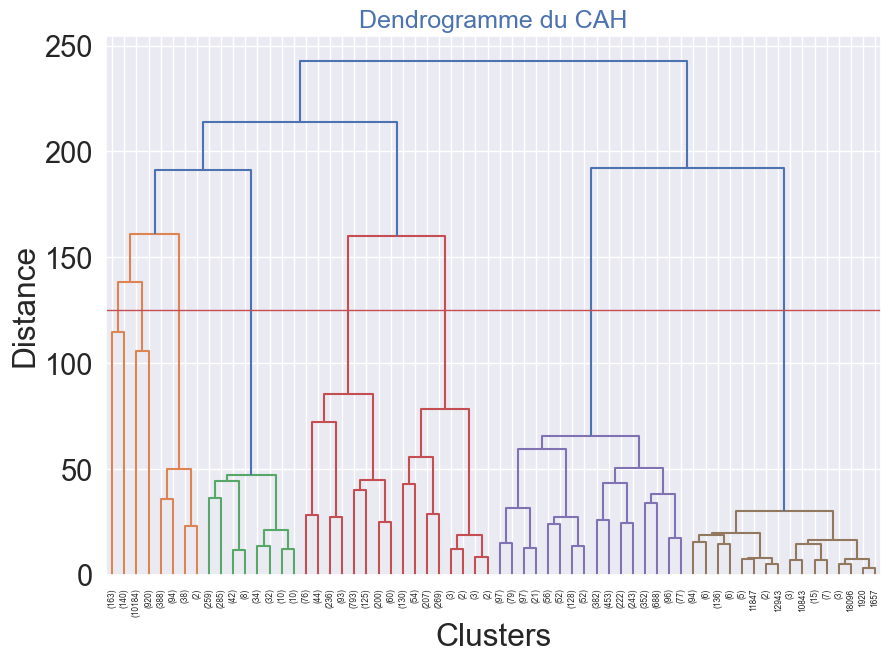

## DBScan

In [289]:
#ACP à 3 axes sur l'échantillon
pca = PCA(n_components = 3)
data_pca = pca.fit_transform(data_sample)

In [290]:
#DBScan
DB = DBSCAN(min_samples=4,eps=2.8)
DB.fit(data_sample)
clus = DB.labels_

In [291]:
pd.DataFrame(clus)[0].value_counts()

 0    17241
 1      679
 2      267
-1       93
 3        4
Name: 0, dtype: int64

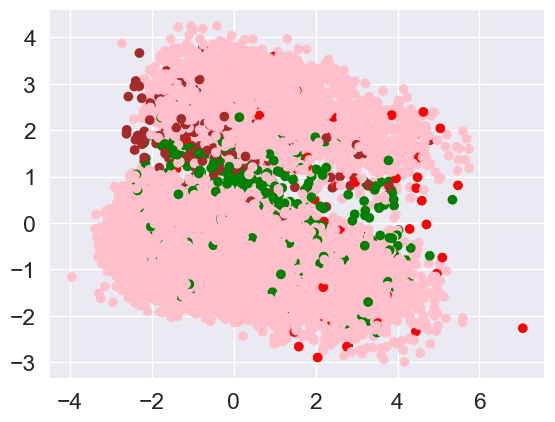

In [292]:
#On affiche les clusters sur le premier plan factoriel
plt.scatter(data_pca[:, 0], data_pca[:, 1], c= clus, cmap=ListedColormap(colors))
plt.show()

# Etude des clusters

In [293]:
#We apply Kmeans
KM = KMeans(n_clusters = 8, random_state=0)
KM.fit(X_norm)
y = KM.labels_

## Cardinalité

<AxesSubplot:xlabel='0', ylabel='count'>

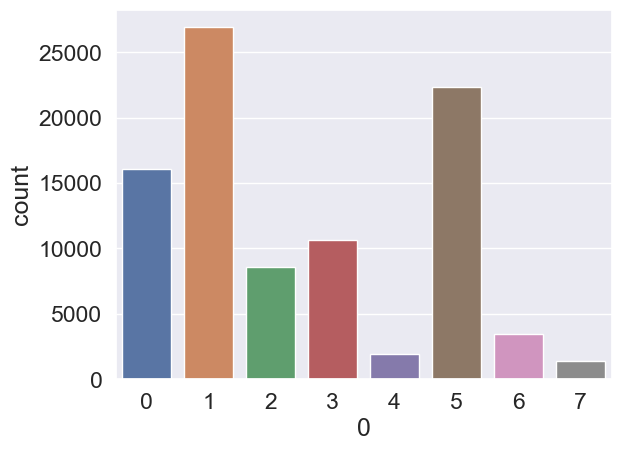

In [294]:
sns.countplot(data=pd.DataFrame(y), x=0)

Les clusters sont peu équilibrés en proportion d'individu.

## Magnitude

<AxesSubplot:xlabel='label'>

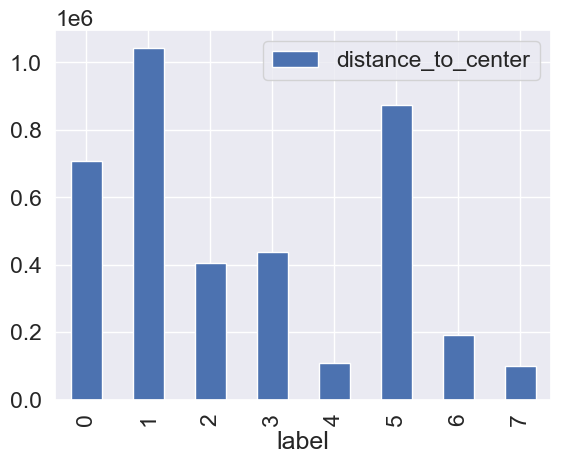

In [295]:
dist = KM.transform(X_norm).sum(axis=1)
df = pd.DataFrame(dist.round(2), columns=['distance_to_center'])
df['label'] = KM.labels_
df.groupby('label').sum().plot(kind='bar')

La magnitude, c'est à dire la somme des distances entre les observations et le centre de leurs clusters respectifs est très peu équilibré.

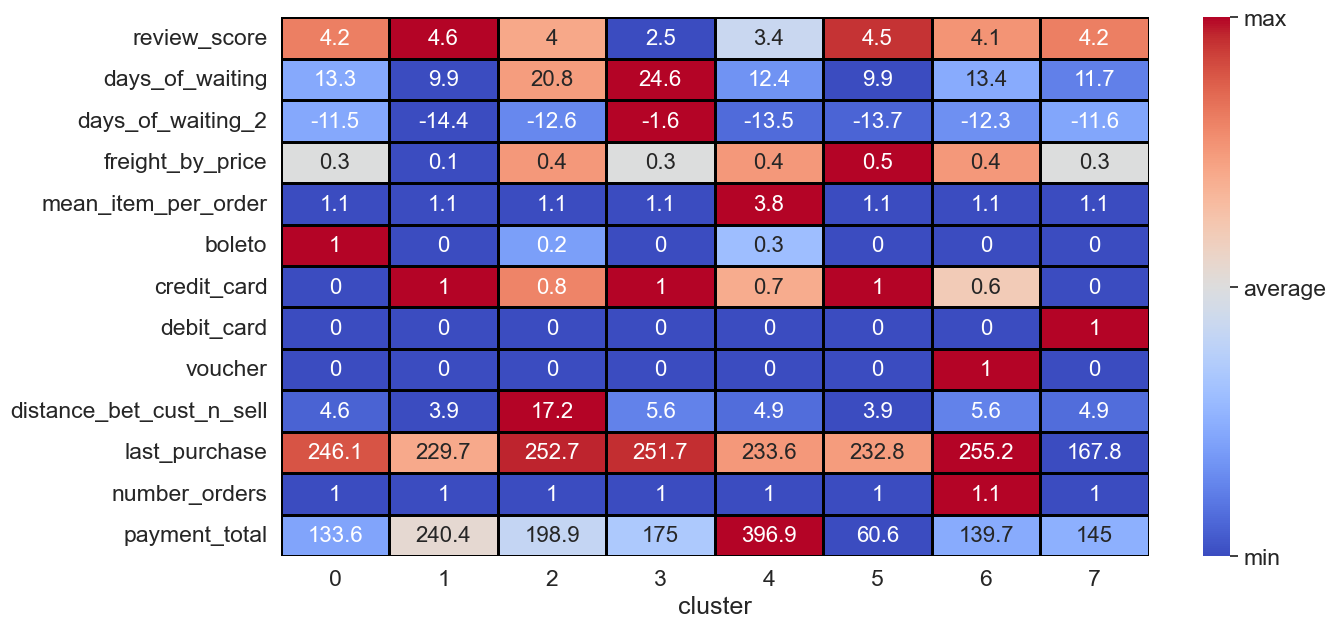

In [296]:
df_full_no_scaled['cluster'] = y
sales = np.round(df_full_no_scaled[['review_score', 'days_of_waiting', 'days_of_waiting_2', 'freight_by_price',
       'mean_item_per_order', 'boleto', 'credit_card', 'debit_card', 'voucher',
       'distance_bet_cust_n_sell', 'last_purchase', 'number_orders',
       'payment_total', 'cluster']].groupby('cluster').mean(),1).T
# create a dataframe grouped by Sources and Category
per_source_cat = np.round(df_full_no_scaled[['review_score', 'days_of_waiting', 'days_of_waiting_2', 'freight_by_price',
       'mean_item_per_order', 'boleto', 'credit_card', 'debit_card', 'voucher',
       'distance_bet_cust_n_sell', 'last_purchase', 'number_orders',
       'payment_total', 'cluster']].groupby('cluster').mean(),1).T
# calculate the maximum for each source
max_per_source = per_source_cat.max(axis=1)
min_per_source = per_source_cat.min(axis=1)
# divide the sales of each source by the maximum for that source
per_source_cat = np.round(df_full_no_scaled[['review_score', 'days_of_waiting', 'days_of_waiting_2', 'freight_by_price',
       'mean_item_per_order', 'boleto', 'credit_card', 'debit_card', 'voucher',
       'distance_bet_cust_n_sell', 'last_purchase', 'number_orders',
       'payment_total', 'cluster']].groupby('cluster').mean(),1).T.sub(min_per_source, axis='index').div(max_per_source - min_per_source,axis=0)*100
sns.set(font_scale=1.5)
plt.figure(figsize=(14,7))
ax = sns.heatmap(per_source_cat, cmap='coolwarm', annot=sales, fmt='g', linewidths=1, linecolor='black',
                annot_kws={"fontsize":16}, xticklabels=True)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 50, 100])
cbar.set_ticklabels(['min', 'average', 'max'])
plt.show()

On peut à l'aide du tableau ci-dessus nommer les différents clusters que l'on vient de trouver : 
- Cluster 0 : only_boleto car ayant uniquement payé en boleto
- Cluster 1 : satisfied car ayant la note moyenne la plus grande / le rapport frêt par prix le plus petit
- Cluster 2 : distant car ayant une moyenne de distance significativement supérieur aux autres
- Cluster 3 : dissatisfied car ayant une moyenne de note significativement inférieure aux autres
- Cluster 4 : spender car ayant une moyenne de dépense total significativement supérieure aux autres
- Cluster 5 : least_spender car ayant un total moyen de paiement très inférieur aux autres
- Cluster 6 : voucher car ayant une moyenne de paiement en bon d'achat égale à 1 contre 0 pour les autres
- Cluster 7 : most_recent car ayant commandé il y a le moins longteps relativement aux autres

In [297]:
df_full_no_scaled.loc[df_full_no_scaled['cluster']==0,'cluster'] = 'only_boleto'
df_full_no_scaled.loc[df_full_no_scaled['cluster']==1,'cluster'] = 'satisfied'
df_full_no_scaled.loc[df_full_no_scaled['cluster']==2,'cluster'] = 'distant'
df_full_no_scaled.loc[df_full_no_scaled['cluster']==3,'cluster'] = 'dissatisfied'
df_full_no_scaled.loc[df_full_no_scaled['cluster']==4,'cluster'] = 'spender'
df_full_no_scaled.loc[df_full_no_scaled['cluster']==5,'cluster'] = 'least_spender'
df_full_no_scaled.loc[df_full_no_scaled['cluster']==6,'cluster'] = 'voucher'
df_full_no_scaled.loc[df_full_no_scaled['cluster']==7,'cluster'] = 'most_recent'

<AxesSubplot:xlabel='last_purchase', ylabel='cluster'>

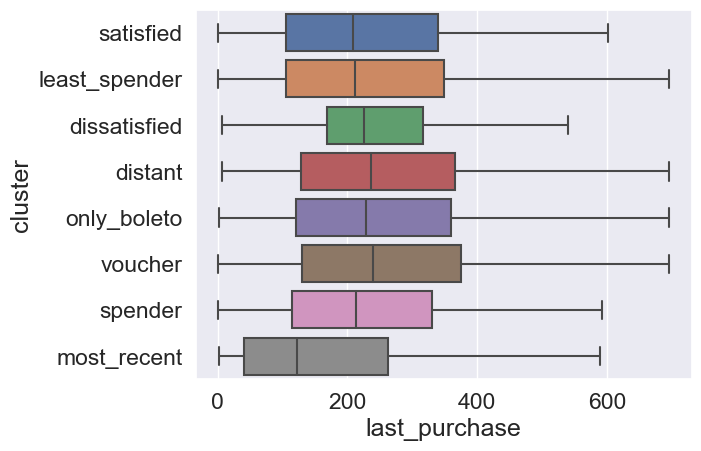

In [298]:
sb.boxplot(y='cluster', x='last_purchase', data=df_full_no_scaled, showfliers = False)

In [299]:
df_full_no_scaled[['number_orders', 'cluster']].groupby('cluster').value_counts()

cluster        number_orders
dissatisfied   1                10296
               2                  351
               3                   18
               4                    3
               5                    1
               9                    1
distant        1                 8326
               2                  213
               3                   13
               4                    4
               6                    2
               5                    2
               7                    1
least_spender  1                21928
               2                  390
               3                   19
               5                    2
               4                    1
most_recent    1                 1369
               2                   61
               3                    2
only_boleto    1                15664
               2                  404
               3                   34
               4                    3
               6     

<AxesSubplot:xlabel='payment_total', ylabel='cluster'>

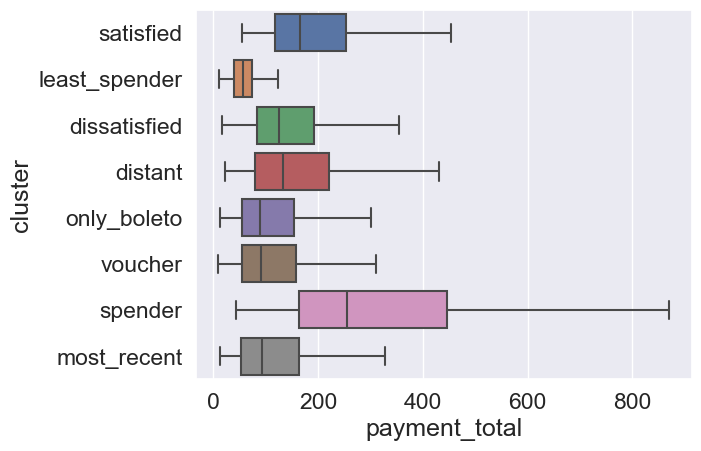

In [300]:
sb.boxplot(y='cluster', x='payment_total', data=df_full_no_scaled, showfliers = False)

<AxesSubplot:xlabel='review_score', ylabel='cluster'>

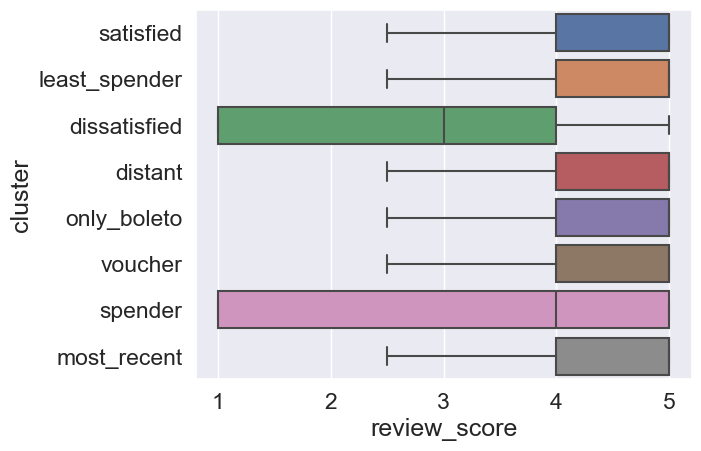

In [301]:
sb.boxplot(y='cluster', x='review_score', data=df_full_no_scaled, showfliers = False)

<AxesSubplot:xlabel='days_of_waiting', ylabel='cluster'>

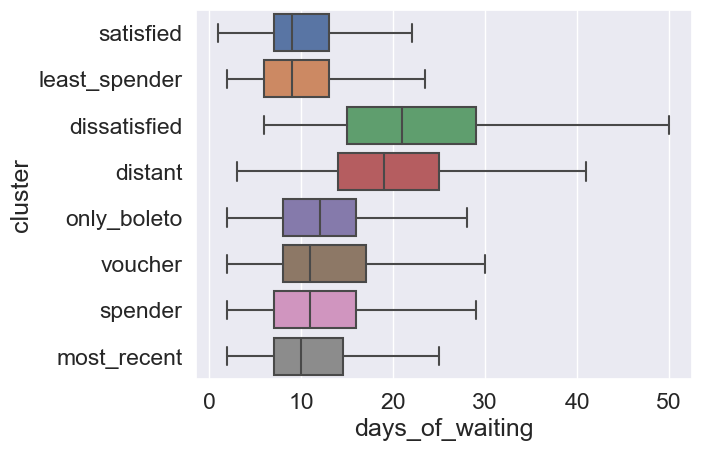

In [302]:
sb.boxplot(y='cluster', x='days_of_waiting', data=df_full_no_scaled, showfliers = False)

<AxesSubplot:xlabel='freight_by_price', ylabel='cluster'>

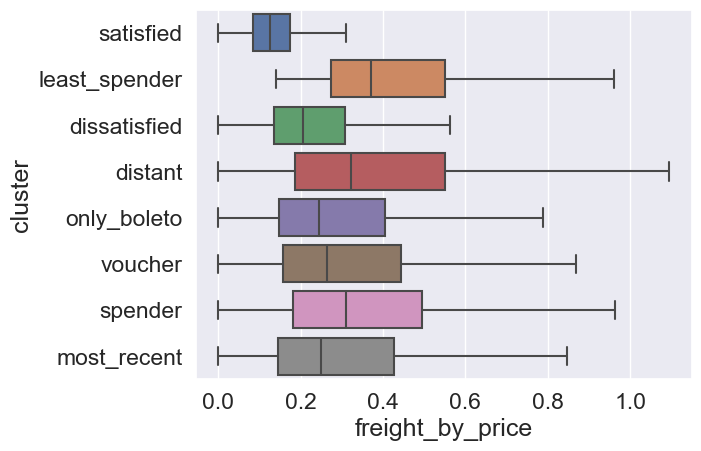

In [303]:
sb.boxplot(y='cluster', x='freight_by_price', data=df_full_no_scaled, showfliers = False)

<AxesSubplot:xlabel='distance_bet_cust_n_sell', ylabel='cluster'>

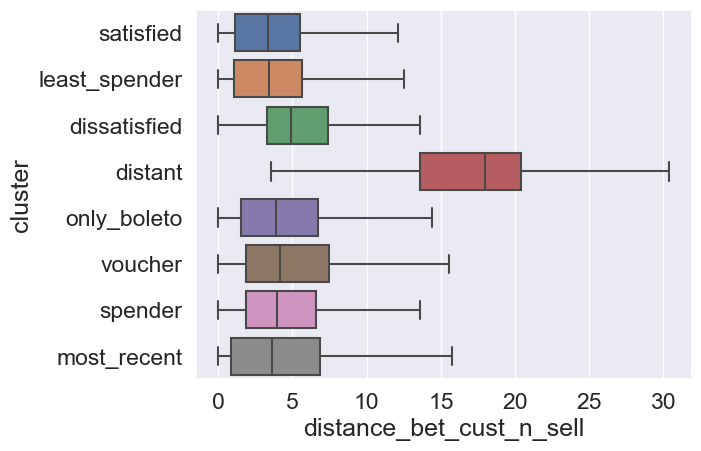

In [304]:
sb.boxplot(y='cluster', x='distance_bet_cust_n_sell', data=df_full_no_scaled, showfliers = False)

<AxesSubplot:xlabel='geolocation_lng', ylabel='geolocation_lat'>

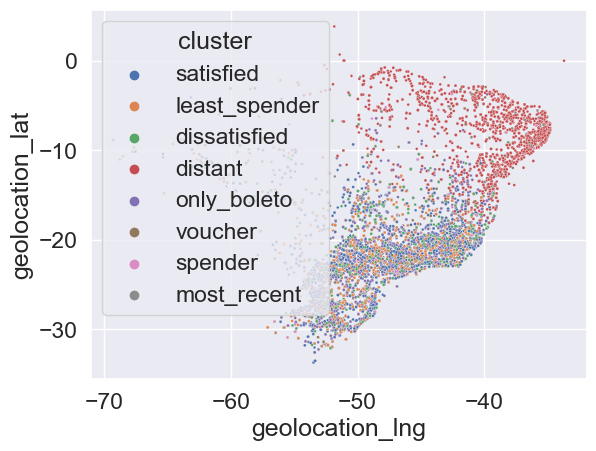

In [305]:
sns.scatterplot(x='geolocation_lng', y='geolocation_lat', data=df_full_no_scaled.loc[(df_full_no_scaled.geolocation_lat<5) & (df_full_no_scaled.geolocation_lng<-30)],
                s=4, hue='cluster')

# Clustering spécifique

Dans cette partie, on veut réaliser un clustering qui ciblera seulement quelques variables de notre dataframe initial. Afin de choisir ces dernières on se base sur l'analyse exploratoire du premier notebook (corrélation, coefficient de variation, pertinence des variables).

In [307]:
#On sélectionne les variables qui nous intéressent
df_2 = df_full[['review_score', 'days_of_waiting', 'freight_by_price', 'mean_item_per_order', 'distance_bet_cust_n_sell',
               'last_purchase', 'number_orders', 'payment_total']]

In [308]:
X_norm = df_2.values

In [309]:
#Find the best number of cluster
intertia_list = []

for i in range(2,14):
    KM = KMeans(n_clusters = i)
    KM.fit(X_norm)
    clus = KM.labels_
    #print(silhouette_score(X_norm,clus))
    intertia_list.append(KM.inertia_)

2 clusters : 0.29052826919863195
\
3 clusters : 0.3071329244367523
\
4 clusters : 0.29614024732454236
\
5 clusters : 0.2997789975577368
\
6 clusters : 0.21144676022607678
\
7 clusters : 0.22081194705253623
\
8 clusters : 0.23316470627625765
\
9 clusters : 0.2395177198774416
\
10 clusters : 0.20617720582735438
\
11 clusters : 0.21155906060637625
\
12 clusters : 0.21391616996440738
\
13 clusters : 0.18372528428670945

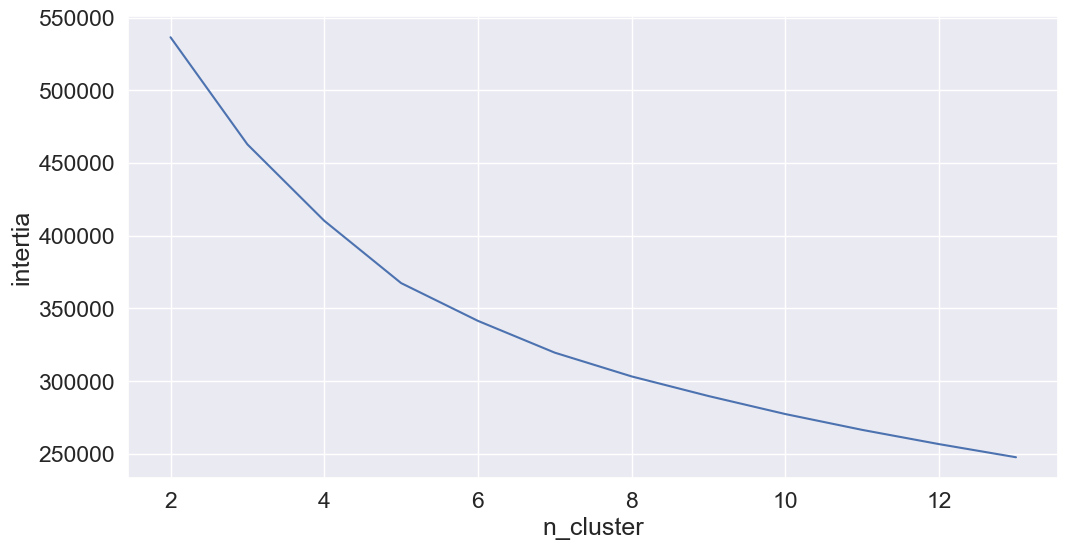

In [310]:
#Affichage de la courbe du nombre de cluster en fonction de l'inertie
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")

ax = plt.plot(range(2, 14), intertia_list)

En se basant sur les résultats précédents on décide de partitionner notre jeu de donnée en 5 clusters.

## K-Means

In [311]:
#K-Means à 5 clusters
KM = KMeans(n_clusters = 5, random_state=1)
KM.fit(X_norm)
clus = KM.labels_

In [312]:
#ACP à 3 composantes
pca = PCA(n_components = 3)
X_pca = pca.fit_transform(X_norm)

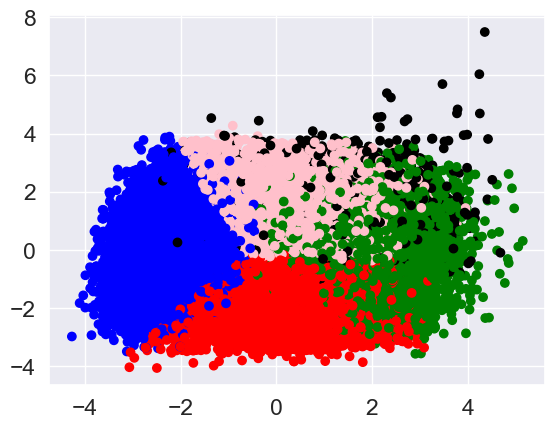

In [313]:
#Affichage des clusters du K-Means
colors = ['red','blue','pink', 'black', 'green']
plt.scatter(X_pca[:, 0], X_pca[:, 1], c= clus, cmap=ListedColormap(colors))
plt.show()

Comme dans les parties précédentes, on réalise un échantillonnage de notre jeu de donnée afin de pouvoir produire notre CAH ainsi que notre DBScan.

## Echantillonnage

In [314]:
#On prends 20% du dataframe initial
data_sample = df_full.sample(frac=0.2, replace=False, random_state=1).values

## CAH

In [315]:
#CAH
#linked = linkage(data_sample, 'ward', metric='euclidean')

#labelList = range(1, data_sample.shape[0]+1)

#plt.figure(figsize=(10, 7))
#dendrogram(linked,
#            orientation='top',
#            labels=labelList,
#            distance_sort='descending',
#            show_leaf_counts=True, truncate_mode='level', p=4)
#plt.axhli#ne(y=175, c='r', linewidth=1)#

#plt.xlabel("Clusters"#)
#plt.ylabel("Distance")
#plt.title("Dendrogramme du CAH",
#          fontsize=18,
#          color="b")

#plt.show()

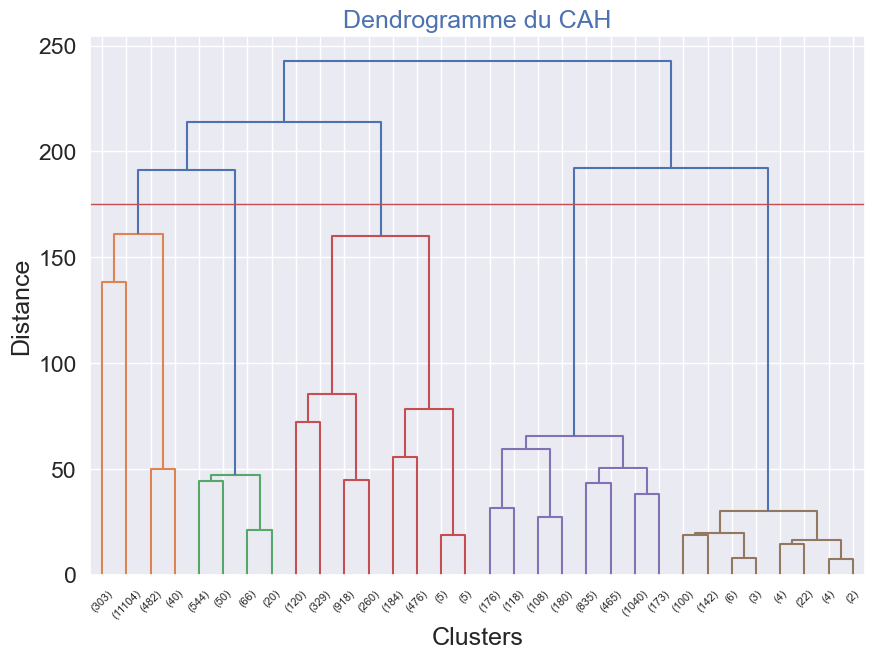

## DBScan

In [316]:
#ACP à 3 composantes
pca = PCA(n_components = 3)
data_pca = pca.fit_transform(data_sample)

In [317]:
#DBScan
DB = DBSCAN(min_samples=4,eps=2.3)
DB.fit(data_sample)
clus = DB.labels_

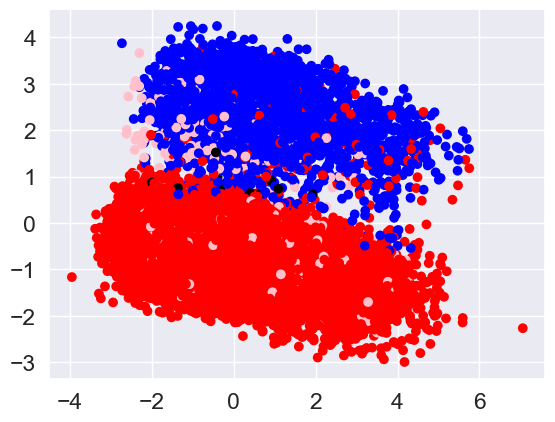

In [318]:
#Clustering du DBScan sur le premier plan factoriel
plt.scatter(data_pca[:, 0], data_pca[:, 1], c= clus, cmap=ListedColormap(colors))
plt.show()

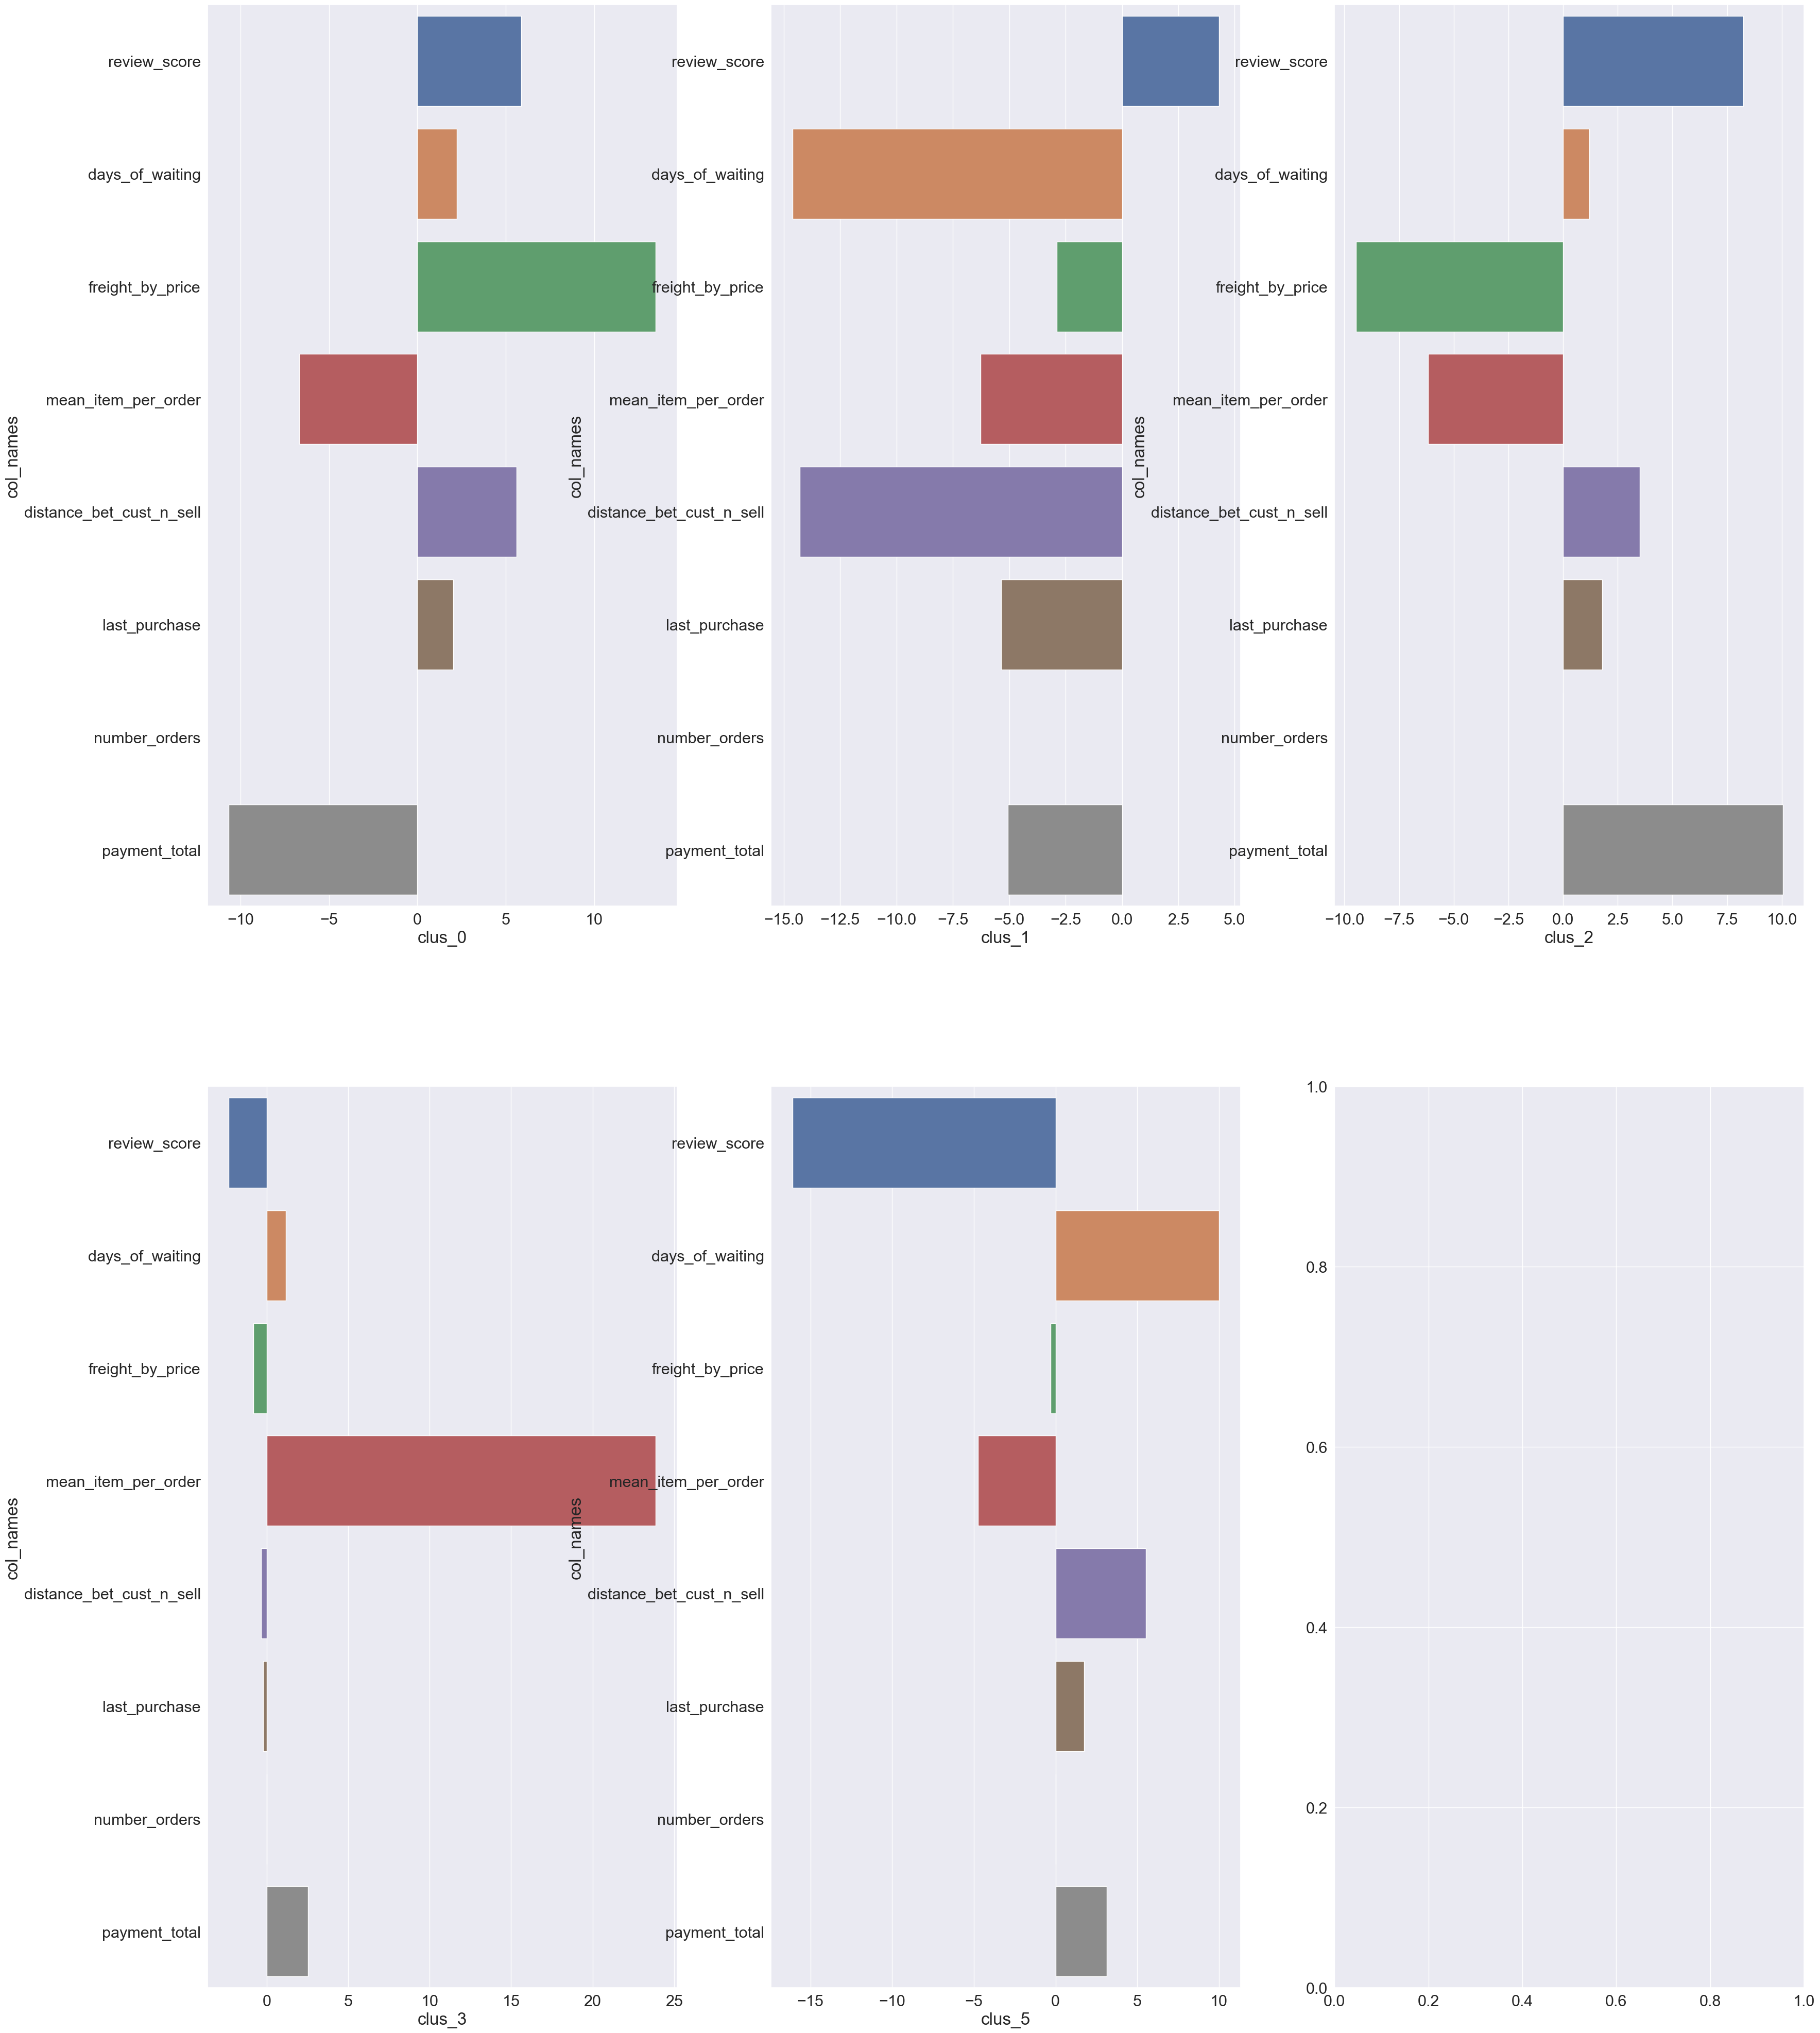

In [319]:
#We apply Kmeans
KM = KMeans(n_clusters = 5, random_state=1)
KM.fit(X_norm)
y = KM.labels_

#We apply the logistic regression
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(penalty='l2')
LR.fit(X_norm,y)

#We vizualize our coefficients
import numpy as np
df_clusInter = pd.DataFrame(np.concatenate((df_2.columns.values.reshape(-1,1), LR.coef_.T),axis=1), 
                            columns=['col_names', 'clus_0', 'clus_1', 'clus_2', 'clus_3', 'clus_5'])

import seaborn as sb
sb.set(font_scale=2)
x_ax = 'col_names'
f, axes = plt.subplots(2, 3,figsize=(40,50))
for i, ax in zip(range(0,5), axes.flat):
    sb.barplot(y=x_ax, x=df_clusInter.columns[1:].tolist()[i], data=df_clusInter,ax=ax)

## Cardinalité

<AxesSubplot:xlabel='0', ylabel='count'>

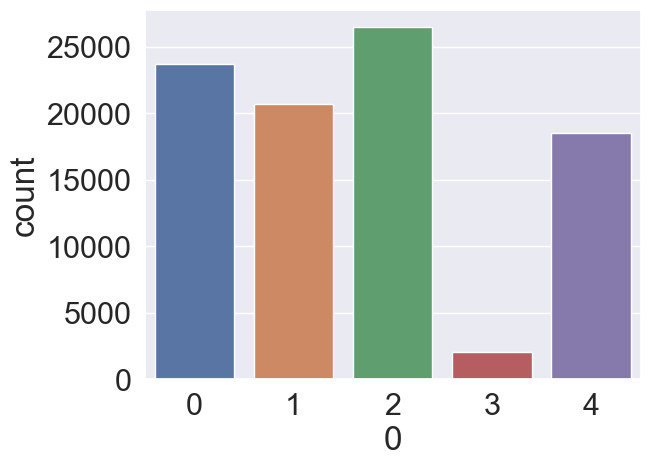

In [320]:
sns.countplot(data=pd.DataFrame(y), x=0)

Les clusters sont peu équilibrés en proportion d'individu.

## Magnitude

<AxesSubplot:xlabel='label'>

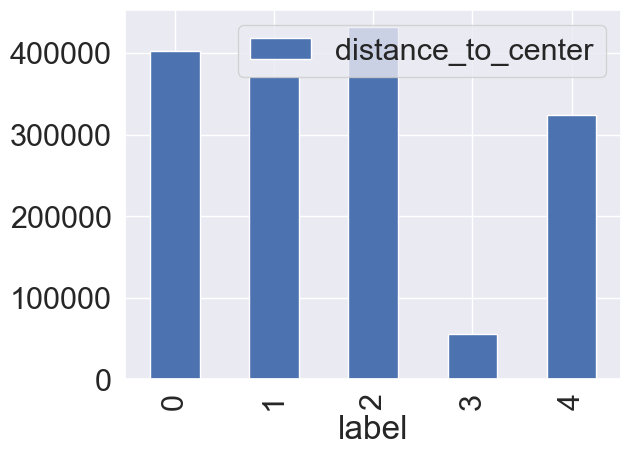

In [321]:
dist = KM.transform(X_norm).sum(axis=1)
df = pd.DataFrame(dist.round(2), columns=['distance_to_center'])
df['label'] = KM.labels_
df.groupby('label').sum().plot(kind='bar')

La magnitude, c'est à dire la somme des distances entre les observations et le centre de leurs clusters respectifs est très peu équilibré.

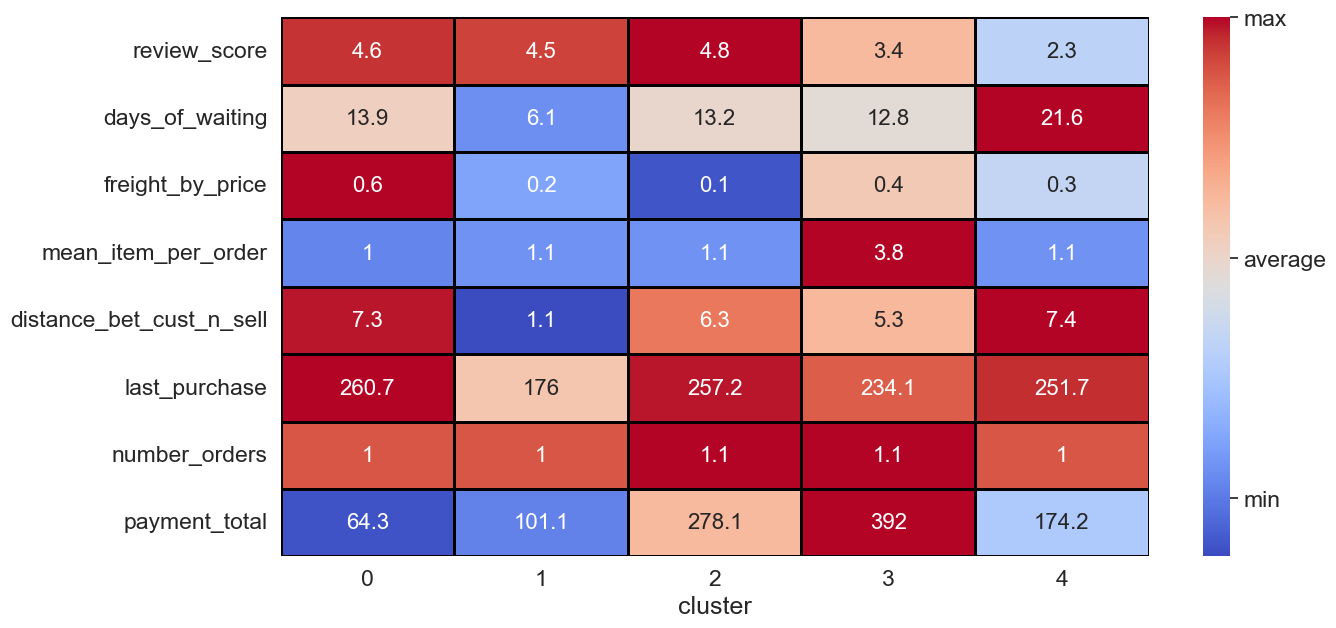

In [322]:
df_full_no_scaled['cluster'] = y
sales = per_source_cat = np.round(df_full_no_scaled[['review_score', 'days_of_waiting', 'freight_by_price', 'mean_item_per_order', 'distance_bet_cust_n_sell',
               'last_purchase', 'number_orders', 'payment_total', 'cluster']].groupby('cluster').mean(),1).T
# create a dataframe grouped by Sources and Category
per_source_cat = np.round(df_full_no_scaled[['review_score', 'days_of_waiting', 'freight_by_price', 'mean_item_per_order', 'distance_bet_cust_n_sell',
               'last_purchase', 'number_orders', 'payment_total', 'cluster']].groupby('cluster').mean(),1).T
# calculate the maximum for each source
max_per_source = per_source_cat.max(axis=1)
# divide the sales of each source by the maximum for that source
per_source_cat = per_source_cat.div(max_per_source, axis=0) * 100
sns.set(font_scale=1.5)
plt.figure(figsize=(14,7))
ax = sns.heatmap(per_source_cat, cmap='coolwarm', annot=sales, fmt='g', linewidths=1, linecolor='black',
                annot_kws={"fontsize":16}, xticklabels=True)
cbar = ax.collections[0].colorbar
cbar.set_ticks([24, 62, 100])
cbar.set_ticklabels(['min', 'average', 'max'])
plt.show()

On peut à l'aide du tableau ci-dessus nommer les différents clusters que l'on vient de trouver : 
- Cluster 0 : small_exepense car leurs dépenses moyennes sont significativement plus basses
- Cluster 1 : closest car ayant une distance à leurs vendeurs / un temps d'attente significativement plus bas
- Cluster 2 : satisfied car ayant la moyenne du rapport frêt par prix la plus basse et la note moyenne la plus haute
- Cluster 3 : spender car ayant une moyenne de paiement total / de nombre total d'article par commande plus haute
- Cluster 4 : dissatisfied car ayant la note moyenne la plus basse / le temps d'attente le plus long

In [323]:
df_full_no_scaled.loc[df_full_no_scaled['cluster']==0,'cluster'] = 'small_exepense'
df_full_no_scaled.loc[df_full_no_scaled['cluster']==1,'cluster'] = 'closest'
df_full_no_scaled.loc[df_full_no_scaled['cluster']==2,'cluster'] = 'satisfied'
df_full_no_scaled.loc[df_full_no_scaled['cluster']==3,'cluster'] = 'spender'
df_full_no_scaled.loc[df_full_no_scaled['cluster']==4,'cluster'] = 'dissatisfied'

<AxesSubplot:xlabel='last_purchase', ylabel='cluster'>

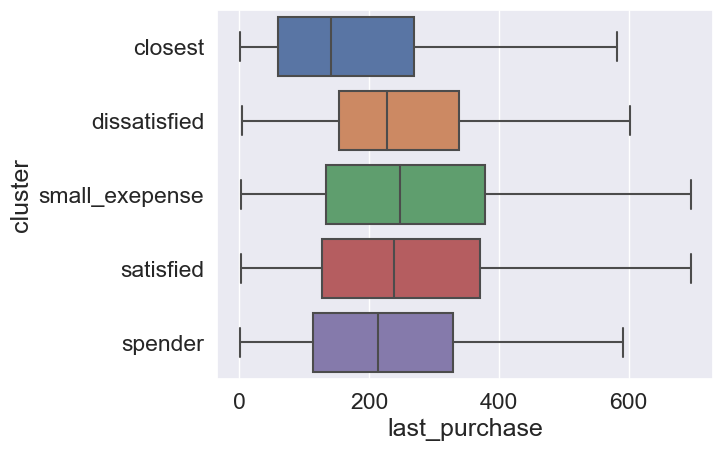

In [324]:
sb.boxplot(y='cluster', x='last_purchase', data=df_full_no_scaled, showfliers = False)

In [325]:
df_full_no_scaled[['number_orders', 'cluster']].groupby('cluster').value_counts()

cluster         number_orders
closest         1                20187
                2                  477
                3                   29
                5                    3
                4                    3
                17                   1
dissatisfied    1                17794
                2                  669
                3                   38
                4                    5
                5                    3
                9                    1
satisfied       1                25324
                2                 1032
                3                   97
                4                   18
                6                    5
                7                    3
                5                    1
small_exepense  1                23232
                2                  452
                3                   25
                4                    3
                5                    1
                6                 

<AxesSubplot:xlabel='payment_total', ylabel='cluster'>

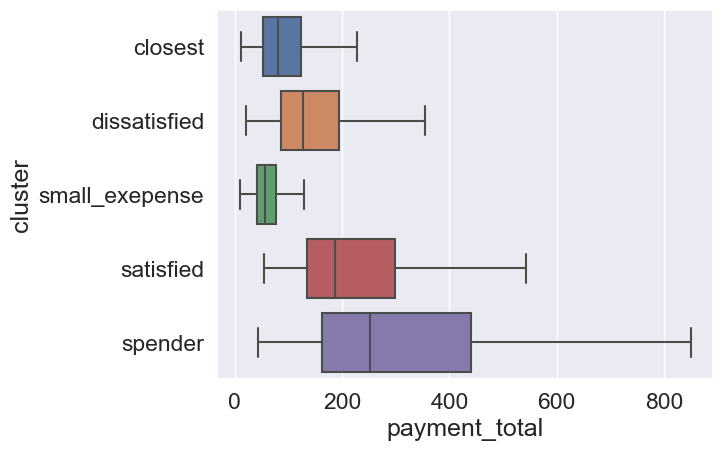

In [326]:
sb.boxplot(y='cluster', x='payment_total', data=df_full_no_scaled, showfliers = False)

<AxesSubplot:xlabel='review_score', ylabel='cluster'>

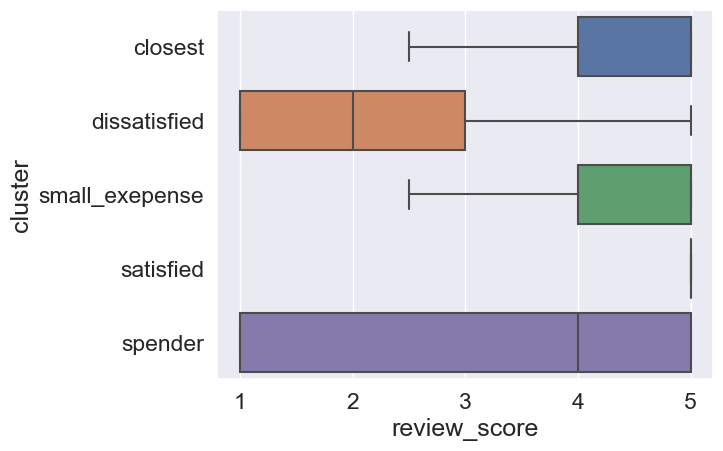

In [327]:
sb.boxplot(y='cluster', x='review_score', data=df_full_no_scaled, showfliers = False)

<AxesSubplot:xlabel='freight_by_price', ylabel='cluster'>

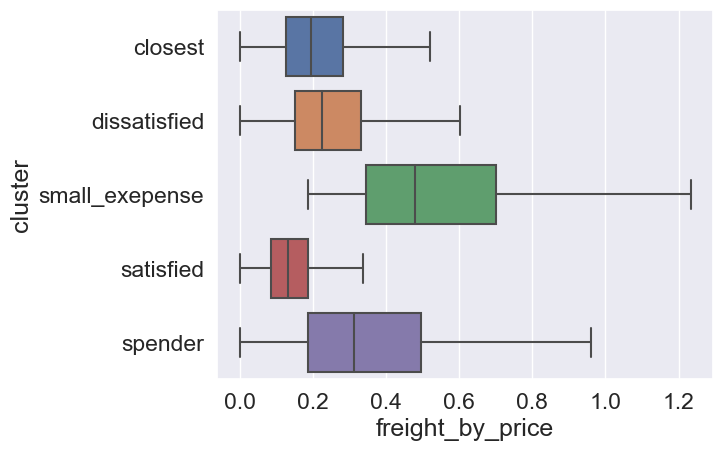

In [328]:
sb.boxplot(y='cluster', x='freight_by_price', data=df_full_no_scaled, showfliers = False)

<AxesSubplot:xlabel='distance_bet_cust_n_sell', ylabel='cluster'>

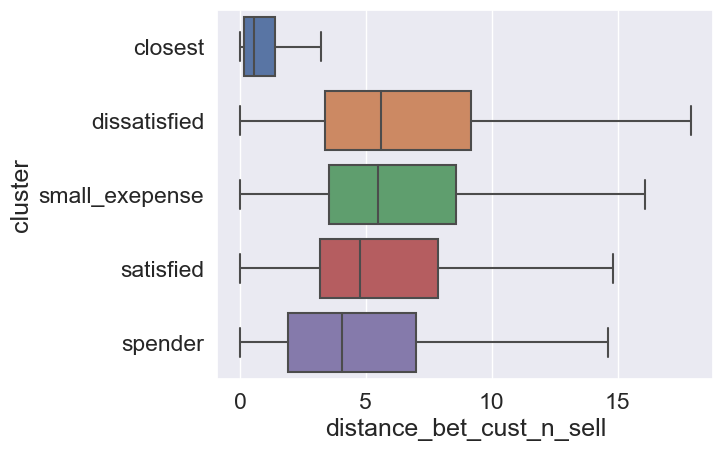

In [329]:
sb.boxplot(y='cluster', x='distance_bet_cust_n_sell', data=df_full_no_scaled, showfliers = False)

<AxesSubplot:xlabel='geolocation_lng', ylabel='geolocation_lat'>

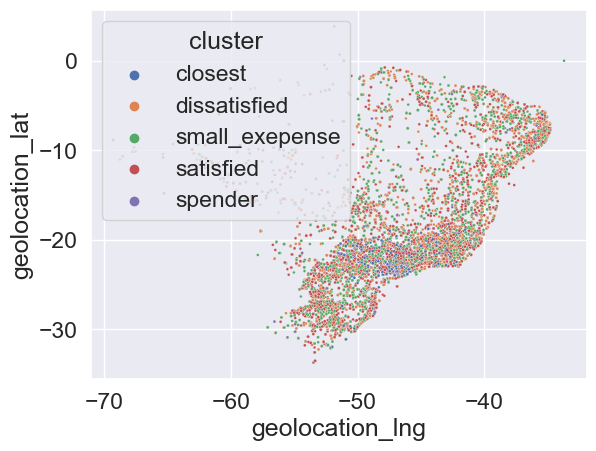

In [330]:
sns.scatterplot(x='geolocation_lng', y='geolocation_lat', data=df_full_no_scaled.loc[(df_full_no_scaled.geolocation_lat<5) & (df_full_no_scaled.geolocation_lng<-30)],
                s=4, hue='cluster')